In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from getpass import getpass
from metaspace import SMInstance

In [2]:
sm = SMInstance()
if not sm.logged_in():
    print('Enter your API key from https://metaspace2020.eu/user/me')
    sm.login(api_key=getpass())
else:
    print('Already logged in')

Already logged in


In [3]:
df = pd.read_csv(r"C:\Users\Veronica\Documents\LAB\projects\spotting\QC\Datasets.csv")

In [4]:
df.head()

,Project,Participant lab,Technology,Martix (if applicable),Shorthand,Polarity,m/z range,Slide Code,Pixel sixe,Additional information,Visible issues?,Visual quality,Annotation QC,Dataset ID,Link
0,20 matrices,EMBL,AP-SMALDI5/Oprbitrap,"2,5-dihydroxybenzoic acid (DHB)",DHB,pos,70-350,7J,150,NaN,NaN,NaN,not done,2021-02-17_18h14m40s,https://metaspace2020.eu/annotations?ds=2021-0...
1,20 matrices,EMBL,AP-SMALDI5/Oprbitrap,"2,5-dihydroxybenzoic acid (DHB)",DHB,pos,300-1510,7J,150,NaN,NaN,NaN,not done,2021-02-19_12h11m04s,https://metaspace2020.eu/annotations?ds=2021-0...
2,20 matrices,EMBL,AP-SMALDI5/Oprbitrap,"2,5-dihydroxybenzoic acid (DHB)",DHB,neg,70-350,7J,150,NaN,NaN,NaN,not done,2021-02-17_15h44m30s,https://metaspace2020.eu/annotations?ds=2021-0...
3,20 matrices,EMBL,AP-SMALDI5/Oprbitrap,"2,5-dihydroxybenzoic acid (DHB)",DHB,neg,300-1510,7J,150,NaN,NaN,NaN,not done,2021-02-17_18h29m11s,https://metaspace2020.eu/annotations?ds=2021-0...
4,20 matrices,EMBL,AP-SMALDI5/Oprbitrap,"1,5-diaminonaphthalene (DAN)",DAN,pos,70-350,7A,150,NaN,NaN,NaN,not done,2021-02-15_17h57m16s,https://metaspace2020.eu/annotations?ds=2021-0...


In [32]:
data_of_interest = (df["Participant lab"] == 'EMBL') & (df["Polarity"] == 'pos') & (df["m/z range"] == '300-1510')
datasets = df[data_of_interest]["Dataset ID"]
titles = df[data_of_interest][["Shorthand","Polarity", "m/z range"]].agg(', '.join, axis=1)

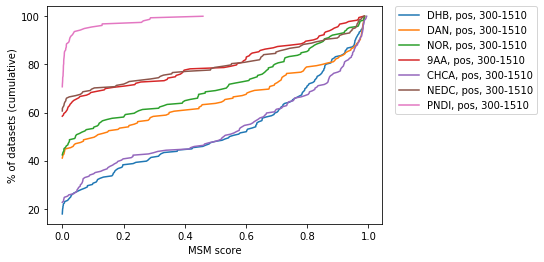

In [33]:
database = ('Spotting_project_compounds-v9', 'feb2021')
fdr=0.5
plt.figure()
plt.xlabel("MSM score")
plt.ylabel("% of datasets (cumulative)")

for i, j in zip(datasets, titles):
    dataset_id = i
    ds = sm.dataset(id=dataset_id)
    results = ds.results(database=database)
#     results.msm.value_counts().sort_index().cumsum().plot(label = j) # counts
    (results.msm.value_counts().sort_index().cumsum() / len(results) * 100).plot(label = j) # %

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=0)
plt.show()

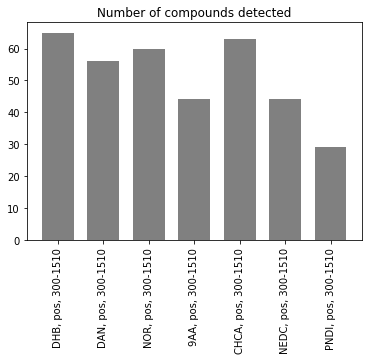

In [34]:
n_unique_all = []

for i in datasets:
    dataset_id = i
    ds = sm.dataset(id=dataset_id)
    results = ds.results(database=database)

    annotations = results[(results.msm > 0)]
    unique = annotations.reset_index()['formula'].unique()
    n_unique = annotations.reset_index()['formula'].nunique()
    n_unique_all.append(n_unique)
    
plt.figure()
plt.bar(titles, n_unique_all, width=0.7, color='grey')
plt.xticks(rotation = 90)
plt.title('Number of compounds detected')
plt.show()

In [26]:
def prep_image(flat_image, h, w):
    img = np.clip(flat_image, np.percentile(flat_image, 1), np.percentile(flat_image, 99)).reshape(h, w)
    img -= np.min(img)
    return img


def make_sum_norm_image(ds, fdr, database, unique):
    # Download annotations & images
    images = ds.all_annotation_images(fdr, database, True, True, offSample=False)
    
    # Put images into a dictionary for easy lookup
    images = dict(((img.formula, img.adduct), img[0]) for img in images if img.formula in unique)

    # Get width & height
    h, w = next(iter(images.values())).shape
    
    # Create a 2D numpy array where each row is a linearized 1D image, 
    # for easy simultaneous manipulation of all images
    images_flat = np.array(list(images.values())).reshape(len(images), -1)
    
    sum_norm_image = prep_image(np.sum(images_flat / np.sum(images_flat, axis=1, keepdims=True), axis=0), h, w)
    return sum_norm_image

In [27]:
sum_images = []

for i in datasets:
    dataset_id = i
    ds = sm.dataset(id=dataset_id)
    results = ds.results(database=database)

    annotations = results[(results.msm > 0)]
    unique = annotations.reset_index()['formula'].unique()
    
    sum_norm_image = make_sum_norm_image(ds, fdr, database, unique)
    sum_images.append(sum_norm_image)

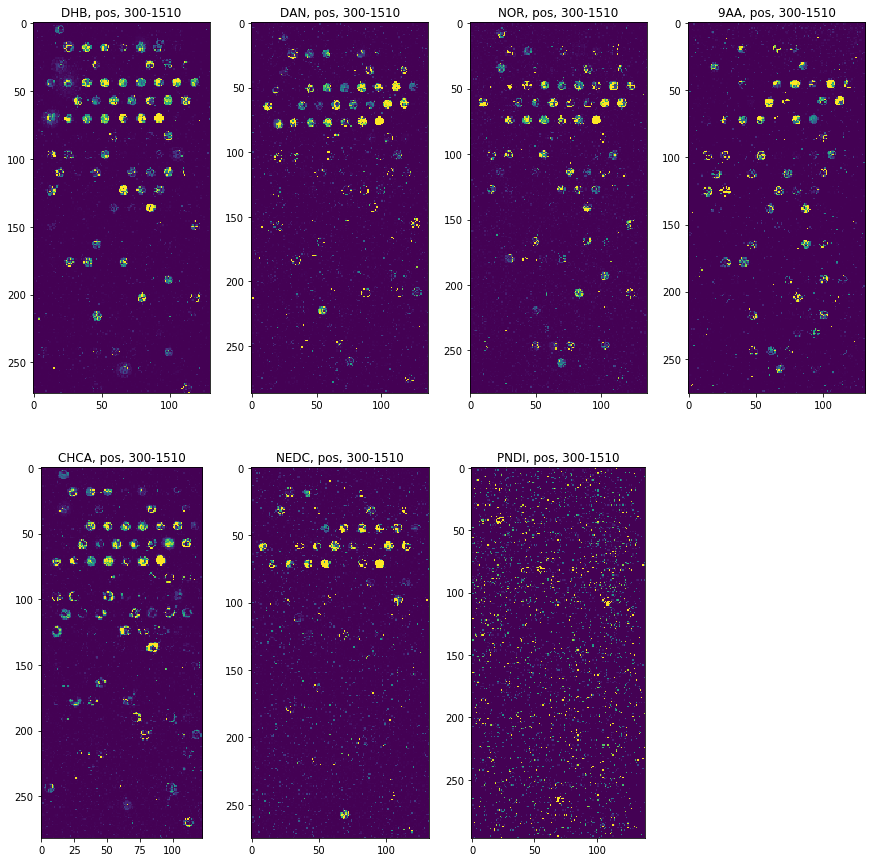

In [28]:
plt.figure(figsize=(15,15))

ncols = 4
nrows = int(np.ceil(len(datasets) / ncols))

for n, (img, title) in enumerate(zip(sum_images, titles)):
    plt.subplot(nrows, ncols, n+1)
    plt.title(title)
    plt.imshow(img)
    
plt.show()